In [1]:
import pandas as pd
import json
import os
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
# sns.set(style='ticks', context='paper', font='CMU Sans Serif')
sns.set(style='ticks', context='paper')
from collections import defaultdict
import numpy as np
from util import plot_cdf,recover_data,color_list

In [2]:
P99_PERCENTILE_LIST = np.arange(1, 101, 1)

MTU=1000
BDP = 10 * MTU
bin_size_list=[MTU, BDP, 5 * BDP]
labels = {0: '0<size<=MTU', 1:'MTU<size<=BDP', 2:'BDP<size<=5BDP', 3:'5BDP<size'}

n_size_bucket_list_output=len(bin_size_list)+1
n_percentiles=len(P99_PERCENTILE_LIST)

In [11]:
# path performance with ours
NR_PATHS_SAMPLED=500

ours_dir='mlsys_final_reprod_v1'
# ours_dir='mlsys'
mlsys_dir_list=["ns3-path-all"]
legend_list=["ns-3-path",'Parsimon','Ours']
mix_file = '../spec/motivation.mix.json'
for mlsys_dir_idx,mlsys_dir in enumerate(mlsys_dir_list):
    save_file=f'./main_{mlsys_dir}_{ours_dir}_{NR_PATHS_SAMPLED}.npz'
    
    if not os.path.exists(save_file):
        p99_sldn_path=defaultdict(list)
        n_flow_per_path_dict=defaultdict(list)
        n_link_per_path_dict=defaultdict(list)
        with open(mix_file) as f:
            mixes = json.load(f) 
        for mix_idx,mix in enumerate(mixes):
            mix_id = mix['id']
            mix_dir = f'../data/{mix_id}'
            # Accuracy metrics
            df_ns3 = pd.read_csv(f'{mix_dir}/ns3/records.csv')
            df_pmn_m = pd.read_csv(f'{mix_dir}/pmn-m/records.csv')
            
            sldn_ns3=df_ns3['slowdown']
            sldn_pmn_m=df_pmn_m['slowdown']
            
            id_to_sldn_ns3=dict(zip(df_ns3['flow_id'],df_ns3['slowdown']))
            id_to_sldn_pmn_m=dict(zip(df_pmn_m['flow_id'],df_pmn_m['slowdown']))
            id_to_size=dict(zip(df_pmn_m['flow_id'],df_pmn_m['size']))
            
            path_idx=0
            while os.path.exists(f'{mix_dir}/{mlsys_dir}/records_{path_idx}.csv'):
                # print(f"mix_id: {mix_id}, path_idx: {path_idx}")
                df_ns3_path = pd.read_csv(f'{mix_dir}/{mlsys_dir}/records_{path_idx}.csv')
                
                flowid_list_path=df_ns3_path['flow_id']
                sldn_ns3_path=df_ns3_path['slowdown']
                
                sldn_ns3_per_path=[id_to_sldn_ns3[flowid] for flowid in flowid_list_path]
                sldn_pmn_m_per_path=[id_to_sldn_pmn_m[flowid] for flowid in flowid_list_path]
                size_per_path=[id_to_size[flowid] for flowid in flowid_list_path]
                
                bins_per_path=np.digitize(size_per_path, bin_size_list)
                
                with open(f'{mix_dir}/{ours_dir}/{path_idx}/fct_mlsys.txt', 'r') as file:
                    sldn_mlsys_per_path = np.array([float(value) for value in file.readline().strip().split()])
                    sldn_mlsys_per_path=sldn_mlsys_per_path.reshape(n_size_bucket_list_output, n_percentiles)
                
                p99_error_per_path_list_tmp=[]
                n_flows_per_path_list_tmp=[]
                for i in range(n_size_bucket_list_output):
                    tmp_sldn_ns3_per_path = np.extract(bins_per_path==i, sldn_ns3_per_path)
                    n_flows_per_path_list_tmp.append(len(tmp_sldn_ns3_per_path))
                    if len(tmp_sldn_ns3_per_path)==0:
                        p99_error_per_path_list_tmp.append([0,0,0])
                        continue
                    tmp_sldn_ns3_p99=np.percentile(tmp_sldn_ns3_per_path,99)
                    
                    tmp_sldn_pmn = np.extract(bins_per_path==i, sldn_pmn_m_per_path)
                    tmp_sldn_pmn_p99=np.percentile(tmp_sldn_pmn,99)
                    
                    tmp_sldn_ns3_path=np.extract(bins_per_path==i, sldn_ns3_path)
                    tmp_sldn_ns3_path_p99=np.percentile(tmp_sldn_ns3_path,99)
                    
                    tmp_sldn_mlsys_p99=sldn_mlsys_per_path[i,-2]
                    
                    error_ns3_path=(tmp_sldn_ns3_path_p99-tmp_sldn_ns3_p99)/tmp_sldn_ns3_p99
                    
                    error_pmn=(tmp_sldn_pmn_p99-tmp_sldn_ns3_p99)/tmp_sldn_ns3_p99
                    
                    error_mlsys=(tmp_sldn_mlsys_p99-tmp_sldn_ns3_p99)/tmp_sldn_ns3_p99
                    p99_error_per_path_list_tmp.append([error_ns3_path,error_pmn,error_mlsys])
                p99_sldn_path[mix_id].append(p99_error_per_path_list_tmp)
                n_flow_per_path_dict[mix_id].append(n_flows_per_path_list_tmp)
                
                with open(f'{mix_dir}/{mlsys_dir}/path_{path_idx}.txt', 'r') as file:
                    lines = file.readlines()
                    data=lines[0].strip().split(",")
                    n_link=len(data[0].split("|"))-1
                    n_link_per_path_dict[mix_id].append(n_link)
                    
                path_idx+=1
            
        np.savez(save_file, p99_sldn_path=p99_sldn_path, n_flow_per_path_dict=n_flow_per_path_dict,n_link_per_path_dict=n_link_per_path_dict)
    else:
        data=np.load(save_file, allow_pickle=True)
        p99_sldn_path=data['p99_sldn_path'].item()
        n_flow_per_path_dict=data['n_flow_per_path_dict'].item()
        n_link_per_path_dict=data['n_link_per_path_dict'].item()
        
print(f"p99_sldn_path: {len(p99_sldn_path)}")

p99_sldn_path: 3


mix_id: 20
p99_sldn_path_per_mix: (499, 4, 3)
n_flow_per_path_dict_per_mix: (499, 4)
n_link_per_path_dict_per_mix: (499,)
mix_id: 179
p99_sldn_path_per_mix: (497, 4, 3)
n_flow_per_path_dict_per_mix: (497, 4)
n_link_per_path_dict_per_mix: (497,)
mix_id: 12
p99_sldn_path_per_mix: (453, 4, 3)
n_flow_per_path_dict_per_mix: (453, 4)
n_link_per_path_dict_per_mix: (453,)
plot_data: [(3, 817), (3, 687), (3, 554), (3, 841)]
plot_data_link: [(3, 880), (3, 1732), (3, 287)]


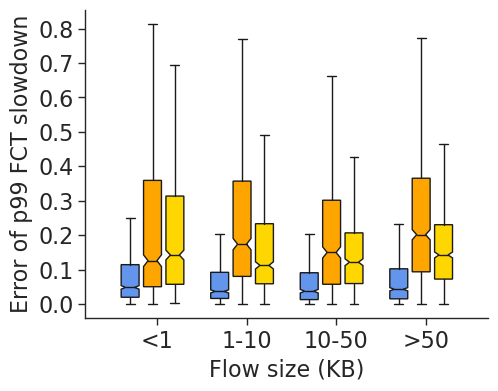

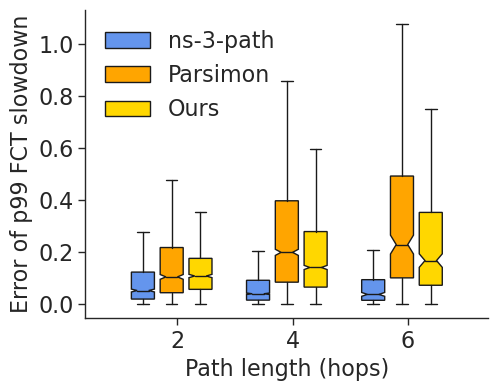

In [12]:
def plot_box_multi(datas, file_name, x_label_name, y_label_name, label=None, legendlabel=None,loc='upper left',
    ncol=1,fontsize=15):
    _fontsize = fontsize
    fig, ax = plt.subplots(figsize=(5.2, 4))

    # Set the width of each boxplot
    box_width = 0.2

    # Calculate the positions for each group
    group_positions = np.arange(len(datas))

    bp_list = []

    for idx in range(len(datas[0])):
        data = [datas[tt][idx] for tt in range(len(datas))]

        # Adjust the x-axis positions based on the current index and group position
        current_positions = group_positions + (idx-1) * (box_width+0.05)

        if label is None:
            bplot = ax.boxplot(
                data,
                positions=current_positions,
                notch=True,
                vert=True,
                patch_artist=True,
                showfliers=False,
                widths=box_width,
            )
        else:
            bplot = ax.boxplot(
                data,
                positions=current_positions,
                notch=True,
                vert=True,
                patch_artist=True,
                labels=label,
                showfliers=False,
                widths=box_width,
            )

        c2 = color_list[idx % len(color_list)]

        for item in ["boxes", "whiskers", "fliers", "medians", "caps"]:
            plt.setp(bplot[item], color='k')

        plt.setp(bplot["boxes"], facecolor=c2,edgecolor='k')
        plt.setp(bplot["fliers"], markeredgecolor='k')

        bp_list.append(bplot["boxes"][0])

    plt.yticks(fontsize=_fontsize)
    plt.xticks(group_positions + (len(datas[0]) / 2) * box_width-0.25, label, fontsize=_fontsize)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if legendlabel:
        ax.legend(bp_list, legendlabel, fontsize=_fontsize, frameon=False,ncol=ncol,loc=loc)

    plt.xlabel(x_label_name, fontsize=_fontsize)
    plt.ylabel(y_label_name, fontsize=_fontsize)

    if file_name:
        plt.savefig(file_name, bbox_inches="tight", pad_inches=0)
        
target_mix_list=[20,179,12]
N_FLOW_THRESHOLD_LIST=[20,20,20]
plot_data=[[] for _ in range(n_size_bucket_list_output)]
plot_data_link=[[] for _ in range(3)]
for mix_idx,mix_id in enumerate(target_mix_list):
    print(f"mix_id: {mix_id}")
    p99_sldn_path_per_mix=np.array(p99_sldn_path[mix_id])
    print(f"p99_sldn_path_per_mix: {p99_sldn_path_per_mix.shape}")
    
    n_flow_per_path_dict_per_mix=np.array(n_flow_per_path_dict[mix_id])
    print(f"n_flow_per_path_dict_per_mix: {n_flow_per_path_dict_per_mix.shape}")
    
    n_link_per_path_dict_per_mix=np.array(n_link_per_path_dict[mix_id])
    print(f"n_link_per_path_dict_per_mix: {n_link_per_path_dict_per_mix.shape}")
    
    for i in range(n_flow_per_path_dict_per_mix.shape[0]):
        for j in range(n_flow_per_path_dict_per_mix.shape[1]):
            if n_flow_per_path_dict_per_mix[i,j]>=N_FLOW_THRESHOLD_LIST[mix_idx]:
                plot_data[j].append(p99_sldn_path_per_mix[i,j])
                
                plot_data_link[n_link_per_path_dict_per_mix[i]//2-1].append(p99_sldn_path_per_mix[i,j])
plot_data=[np.abs(x).transpose() for x in plot_data]
print(f"plot_data: {[x.shape for x in plot_data]}")

plot_data_link=[np.abs(x).transpose() for x in plot_data_link]
print(f"plot_data_link: {[x.shape for x in plot_data_link]}")

# for i in range(len(plot_data)):
#     plot_cdf(plot_data[i],None,legend_list,'Error of p99 FCT slowdown',legend_font=15,group_size=3,loc=4,rotate_xaxis=False,xlim=1.0,xlim_bottom=0.001)

plot_box_multi(
    plot_data,
    'figs/intermediate_path_size.pdf',
    'Flow size (KB)',
    'Error of p99 FCT slowdown',
    label=['<1', '1-10', '10-50', '>50'],
    legendlabel=None,
    loc='upper left',
    ncol=1,
    fontsize=16
)

plot_box_multi(
    plot_data_link,
    'figs/intermediate_path_link.pdf',
    'Path length (hops)',
    'Error of p99 FCT slowdown',
    label=[2, 4, 6],
    legendlabel=legend_list,
    loc='upper left',
    ncol=1,
    fontsize=16
)

error_abs-median: [0.05978415660828611, 0.029905701154412167, 0.012033388760568467, 0.010257129982992691, 0.004124968630292373]
error_abs-max: [0.4871533897306813, 0.3281223658601989, 0.09960812702601571, 0.07035888590264956, 0.05337764794246735]
error_real: [0.06932130954774689, 0.0005524515667491622, 0.0012996925078767286, 0.000957305730512249, -0.001086391530732906]


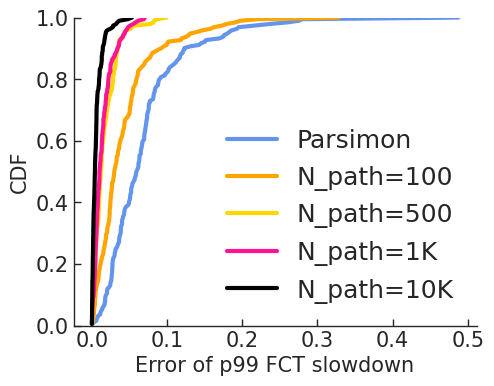

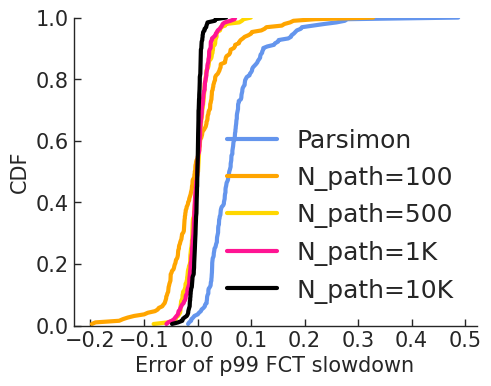

In [28]:
# with percentile sampling for s1
res=[]
sample_mode_str_list=['1_1_100_100','1_1_500_100','1_1_1000_100','1_1_10000_100']
legend_list=['ns-3','Parsimon','N_path=100','N_path=500','N_path=1K','N_path=10K']
for sample_mode in range(len(sample_mode_str_list)):
    sample_mode_str=sample_mode_str_list[sample_mode]
    opt_file=f"./gen_opt_{sample_mode_str}.npy"
    tmp=np.load(opt_file)
    val=tmp[:,0,:].transpose() 
    if sample_mode==0:
        res.append(val[0])
        res.append(val[1])
        res.append(val[2])
    else:
        res.append(val[2])

error_abs=[]
for i in range(1,len(res)):
    error_abs.append(np.abs(res[i]-res[0])/res[0])
plot_cdf(error_abs,'figs/intermediate_sampling_error.pdf',[legend_list[i] for i in range(1,len(legend_list))],'Error of p99 FCT slowdown',legend_font=18,group_size=len(error_abs),loc=4,rotate_xaxis=False)
mean_val_list=[np.median(error_abs[i]) for i in range(len(error_abs))]
print("error_abs-median:", mean_val_list)
mean_val_list=[np.max(error_abs[i]) for i in range(len(error_abs))]
print("error_abs-max:", mean_val_list)

error_real=[]
for i in range(1,len(res)):
    error_real.append((res[i]-res[0])/res[0])
mean_val_list=[np.mean(error_real[i]) for i in range(len(error_real))]
print("error_real:", mean_val_list)
plot_cdf(error_real,None,[legend_list[i] for i in range(1,len(legend_list))],'Error of p99 FCT slowdown',legend_font=18,group_size=len(error_real),loc=4,rotate_xaxis=False)

In [16]:
save_path="/data2/lichenni/ns3"
file2matrix = {
        '../../workload/spatials/cluster_a_2_16.json': 'Matrix A',
        '../../workload/spatials/cluster_b_2_16.json': 'Matrix B',
        '../../workload/spatials/cluster_c_2_16.json': 'Matrix C',
    }
file2oversub = {
        'spec/cluster_1_to_1.json': '1-to-1',
        'spec/cluster_2_to_1.json': '2-to-1',
        'spec/cluster_4_to_1.json': '4-to-1',
    }

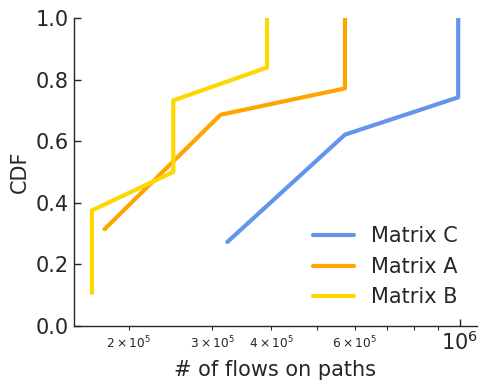

In [30]:
res=defaultdict(list)
mix_file = '../spec/all.mix.json'
with open(mix_file) as f:
    mixes = json.load(f) 
for mix_id in range(192):
    mix=mixes[mix_id]
    mix_dir = f'../data/{mix_id}'
    # Accuracy metrics
    file_path_to_flowId=f'{save_path}/path_to_flowId_{mix_id}.npz'
    
    traffic_mat=file2matrix[mix['spatial']]
    oversub=file2oversub[mix['cluster']],
    
    data=np.load(file_path_to_flowId, allow_pickle=True)
    path_to_flowid=data['path_to_flowid'].item()
    
    key_val=f"{traffic_mat}"
    res[key_val].append(len(path_to_flowid))
legend_list=list(res.keys())
val=[np.array(res[key]) for key in res] 
plot_cdf(val,None,legend_list,'# of flows on paths',legend_font=15,group_size=4,loc=4,rotate_xaxis=False,log_switch=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


val: [167323 167324 167325 177993 248486 248487 248488 312521 323123 391682
 391683 391684 572010 572011 572051 991511 991516]


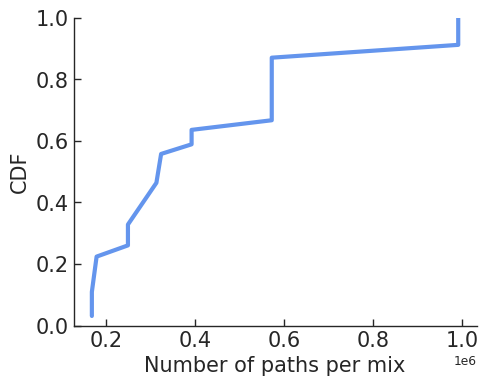

In [31]:
val=[]
for key in res:
    val.extend(res[key])
print(f"val: {np.unique(val)}")
plot_cdf([np.array(val)],'figs/intermediate_sampling_path_num.pdf',[''],'Number of paths per mix',legend_font=15,group_size=4,loc=4,rotate_xaxis=False,log_switch=False)

In [6]:
# [FINAL] no post-processing, cdf of p99 SLOWDOWN, get the mean slowdown across size buckets and then calculate the error percentage
dir_input_synthetic="/data2/lichenni/path/input"
topo_type="_topo-pl-x-x_dctcp"
data_list_seeds = []
lr=10
P99_PERCENTILE_LIST = P99_PERCENTILE_LIST = np.array(
    [30, 50, 60, 70, 75, 80, 82, 84, 86,88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
)
SIZE_BUCKET_LIST_LABEL=[
    "(0, 0.25MTU)",
    "(0.25MTU, 0.5MTU)",
    "(0.5MTU, 0.75MTU)",
    "(0.75MTU, MTU)",
    "(MTU, 0.2BDP)",
    "(0.2BD, 0.5BDP)",
    "(0.5BDP, 0.75BDP)",
    "(0.75BDP, BDP)",
    "(BDP, 5BDP)",
    "(5BDP, INF)",
]
BDP_DICT = {
    2: 10.5 * MTU,
    3: 14 * MTU,
    4: 17.5 * MTU,
    5: 21 * MTU,
    6: 24.5 * MTU,
    7: 28 * MTU,
    8: 31.5 * MTU,
    9: 34 * MTU,
}
SIZE_BUCKET_LIST_LABEL_OUTPUT = ["(0, MTU)", "(MTU, BDP)", "(BDP, 5BDP)", "(5BDP, INF)"]
DELAY_PROPAGATION_BASE = 1000  # 1us
HEADER_SIZE = 48
BYTE_TO_BIT = 8

def get_size_bucket_list_output(mtu, bdp):
    return np.array([mtu, bdp, 5 * bdp])


yticklabels=SIZE_BUCKET_LIST_LABEL
xticklabels=[f"{x}%" for x in P99_PERCENTILE_LIST]
x_len = len(SIZE_BUCKET_LIST_LABEL)
x_len_output = len(SIZE_BUCKET_LIST_LABEL_OUTPUT)
y_len = len(P99_PERCENTILE_LIST)
lr=10
    
dir_output="/data2/lichenni/output_1116"
program_name_list=['baseline_error_noweighted_shard3000_nflows1_nhosts7_lr10Gbps',
                   'm3_error_noweighted_shard3000_nflows1_nhosts7_lr10Gbps',
                   ]
version_id_list=[
    [0],[0]
]

file_tag = "-abs"
enable_abs = False
title_str_list = ["flowSim", "Ours w/o context","Ours"]
main_title_list=['train','test','empirical']
fig_index=0
version_id_test=1
res_p99=[]
for program_name_idx,program_name in enumerate(program_name_list):
    for version_id in version_id_list[program_name_idx]:
        dir_train=f"{dir_output}/{program_name}/version_{version_id}/"
        print(f"dir_train: {dir_train}")
        if version_id_test==0 or version_id_test==1:
            f = open(f"{dir_train}/data_list.json", "r")
            data_list = json.loads(f.read())
            if version_id_test==0:
                data_list_test=data_list["train"]
                data_list_test_idx=np.random.choice(np.arange(len(data_list_test)),size=len(data_list_test)//10,replace=False)
                data_list_test=[data_list_test[i] for i in data_list_test_idx]
            else:
                data_list_test=data_list["test"]
                
            dir_input=dir_input_synthetic
        
        len_tracks=len(data_list_test)
        print(f"{program_name} loads {len_tracks} tracks")
        res_cdf=[]
        for spec,src_dst_pair_target,_ in data_list_test:
            src_dst_pair_target_str="_".join([str(x) for x in src_dst_pair_target])
            data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}_{src_dst_pair_target_str}/res.npz')
            sizebucket_to_sldn_est = data['sizebucket_to_sldn_est']
            sizebucket_to_sldn = data['sizebucket_to_sldn']
            num_flows_per_cell = data['num_flows_per_cell']
            
            num_flows_per_cell_mat=num_flows_per_cell.reshape(x_len_output,y_len)
            
            sizebucket_to_sldn_est=sizebucket_to_sldn_est.reshape(x_len_output,y_len)
            sizebucket_to_sldn=sizebucket_to_sldn.reshape(x_len_output,y_len)
            sizebucket_to_sldn_est=np.clip(sizebucket_to_sldn_est,a_min=1.0,a_max=None)
            sizebucket_to_sldn_est[num_flows_per_cell_mat==0]=None
            sizebucket_to_sldn[num_flows_per_cell_mat==0]=None
            sizebucket_to_sldn=sizebucket_to_sldn[:,-1]
            sizebucket_to_sldn_est=sizebucket_to_sldn_est[:,-1]
            
            if program_name_idx==0:
                sizebucket_to_sldn_flowsim=np.zeros_like(sizebucket_to_sldn_est)
                tmp = spec.split("_")
                n_hosts=int(tmp[2][6:])
                BDP=BDP_DICT[n_hosts]
                size_bucket_list = get_size_bucket_list_output(mtu=MTU,bdp=BDP)

                flow_src_dst = np.load(f'{dir_input}/{spec}/flow_src_dst.npy')
                sizes = np.load(f'{dir_input}/{spec}/flow_sizes.npy')
                n_links_passed=abs(src_dst_pair_target[0]-src_dst_pair_target[1])+2
                
                i_fcts_flowsim = (sizes + np.ceil(sizes / MTU) * HEADER_SIZE) * BYTE_TO_BIT/lr+DELAY_PROPAGATION_BASE*n_links_passed
                fcts_flowsim=np.load(f'{dir_input}/{spec}/fcts_flowsim.npy')+DELAY_PROPAGATION_BASE*n_links_passed
                sldns_flowsim=np.divide(fcts_flowsim, i_fcts_flowsim)
                
                
                flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
                sizes=sizes[flow_idx_target]
                sldns_flowsim=sldns_flowsim[flow_idx_target]

                bins=np.digitize(sizes,size_bucket_list)
                
                for x_idx in range(x_len_output):
                    sldn_idx_target = np.nonzero(bins == x_idx)[0]
                    if len(sldn_idx_target) < 100:
                        continue
                    sldns_tmp = sldns_flowsim[sldn_idx_target]
                    sizebucket_to_sldn_flowsim[x_idx] = np.percentile(
                        sldns_tmp, 99
                    )
                sizebucket_to_sldn_flowsim[num_flows_per_cell_mat[:,-1]==0]=None
            if program_name_idx==0:
                res=[np.divide((sizebucket_to_sldn_flowsim-sizebucket_to_sldn),sizebucket_to_sldn,out=np.zeros_like(sizebucket_to_sldn),
                        where=sizebucket_to_sldn != None),np.divide((sizebucket_to_sldn_est-sizebucket_to_sldn),sizebucket_to_sldn,out=np.zeros_like(sizebucket_to_sldn),
                            where=sizebucket_to_sldn != None)]
            else:
                res=[np.divide((sizebucket_to_sldn_est-sizebucket_to_sldn),sizebucket_to_sldn,out=np.zeros_like(sizebucket_to_sldn),
                            where=sizebucket_to_sldn != None)]
            
            res_cdf_tmp=[]
            for i in range(len(res)):
                p99=res[i]
                if enable_abs:
                    p99=abs(p99)
                res_cdf_tmp.extend(p99)
            res_cdf.append(res_cdf_tmp)
        if program_name_idx==0:
            res_cdf=np.array(res_cdf)
            for i in range(2):
                res_p99.append(res_cdf[:,i*4:i*4+4])
        else:
            res_p99.append(res_cdf)
res_p99=np.array(res_p99)
print(res_p99.shape)

for i in range(res_p99.shape[-1]):
    res=res_p99[:,:,i]
    linelabels_list = []
    for j in range(len(program_name_list)+1):
        median_tmp=np.round(np.nanmedian(res[j]),3)
        max_tmp=np.round(np.nanpercentile(res[j],99),3)
        linelabels_list.append(f"{title_str_list[j]}-"+"{:0.3f}-".format(median_tmp)+"{:0.3f}".format(max_tmp))

dir_train: /data2/lichenni/output_1116/baseline_error_noweighted_shard3000_nflows1_nhosts7_lr10Gbps/version_0/
baseline_error_noweighted_shard3000_nflows1_nhosts7_lr10Gbps loads 2100 tracks


dir_train: /data2/lichenni/output_1116/m3_error_noweighted_shard3000_nflows1_nhosts7_lr10Gbps/version_0/
m3_error_noweighted_shard3000_nflows1_nhosts7_lr10Gbps loads 2100 tracks
(3, 2100, 4)


plot_data: (4, 3, 2100)
[[-0.6566901   0.2440426   0.06600849]
 [ 0.8525154   0.16188869  0.02875398]
 [ 0.23129286  0.10787924  0.04113859]
 [-0.18851164  0.02633141 -0.10099343]]


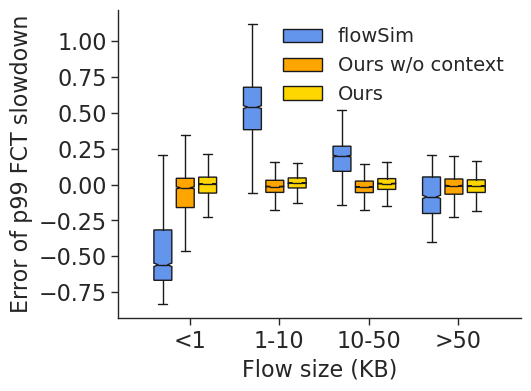

In [10]:
def plot_box_multi(datas, file_name, x_label_name, y_label_name, label=None, legendlabel=None,loc='upper left',
    ncol=1,fontsize=15):
    _fontsize = fontsize
    fig, ax = plt.subplots(figsize=(5.2, 4))

    # Set the width of each boxplot
    box_width = 0.2

    # Calculate the positions for each group
    group_positions = np.arange(len(datas))

    bp_list = []

    for idx in range(len(datas[0])):
        data = []
        for tt in range(len(datas)):
            tmp=np.array(datas[tt][idx])
            tmp=tmp[~np.isnan(tmp)]
            data.append(tmp)

        # Adjust the x-axis positions based on the current index and group position
        current_positions = group_positions + (idx-1) * (box_width+0.05)

        if label is None:
            bplot = ax.boxplot(
                data,
                positions=current_positions,
                notch=True,
                vert=True,
                patch_artist=True,
                showfliers=False,
                widths=box_width,
            )
        else:
            bplot = ax.boxplot(
                data,
                positions=current_positions,
                notch=True,
                vert=True,
                patch_artist=True,
                labels=label,
                showfliers=False,
                widths=box_width,
            )

        c2 = color_list[idx % len(color_list)]

        for item in ["boxes", "whiskers", "fliers", "medians", "caps"]:
            plt.setp(bplot[item], color='k')

        plt.setp(bplot["boxes"], facecolor=c2,edgecolor='k')
        plt.setp(bplot["fliers"], markeredgecolor='k')

        bp_list.append(bplot["boxes"][0])

    plt.yticks(fontsize=_fontsize)
    plt.xticks(group_positions + (len(datas[0]) / 2) * box_width-0.25, label, fontsize=_fontsize)
    
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if legendlabel:
        ax.legend(bp_list, legendlabel, fontsize=_fontsize-2, frameon=False,ncol=ncol,loc=loc)

    plt.xlabel(x_label_name, fontsize=_fontsize)
    plt.ylabel(y_label_name, fontsize=_fontsize)
    # plt.ylim(0,1.0)
    if file_name:
        plt.savefig(file_name, bbox_inches="tight", pad_inches=0)
        

plot_data=np.array([(res_p99[:,:,i]) for i in range(res_p99.shape[2])])
print(f"plot_data: {plot_data.shape}")

print(plot_data[:,:,0])
plot_box_multi(
    plot_data,
    'figs/intermediate_mltesting_size.pdf',
    'Flow size (KB)',
    'Error of p99 FCT slowdown',
    label=['<1', '1-10', '10-50', '>50'],
    legendlabel=title_str_list,
    loc='upper right',
    ncol=1,
    fontsize=16,
)

m3_error_noweighted_shard3000_nflows1_nhosts7_lr10Gbps loads 2100 tracks
['shard1549_nflows30000_nhosts7_lr10Gbps', [0, 6], '_topo-pl-7-7_dctcp']
num_links: [1 2 3 4 5 6 7]
plot_data: [(3, 1128), (3, 1128), (3, 1176)]


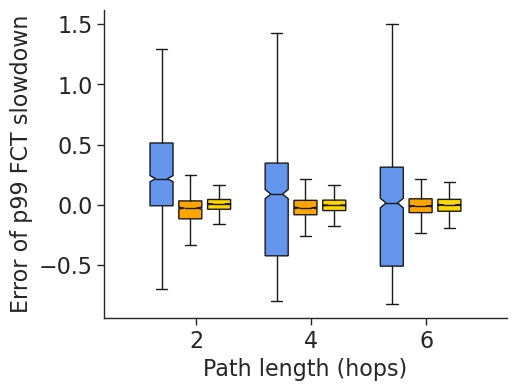

In [9]:
f = open(f"{dir_train}/data_list.json", "r")
data_list = json.loads(f.read())
data_list_test=data_list["test"]

len_tracks=len(data_list_test)
print(f"{program_name} loads {len_tracks} tracks")
num_links=[]
print(data_list_test[0])
for spec,src_dst_pair_target,_ in data_list_test:
    src_dst_pair_target_str="_".join([str(x) for x in src_dst_pair_target])
    num_links.append(abs(src_dst_pair_target[0]-src_dst_pair_target[1]))
print(f"num_links: {np.unique(num_links)}")

# (3, 2100, 4)

plot_data=[[] for _ in range(3)]
for i in range(len(num_links)):
    if num_links[i]==2:
        plot_data[0].extend((res_p99[:,i,:]).transpose())
    elif num_links[i]==4:
        plot_data[1].extend((res_p99[:,i,:]).transpose())
    elif num_links[i]==6:
        plot_data[2].extend((res_p99[:,i,:]).transpose())
plot_data=[np.array(x).transpose() for x in plot_data]
print(f"plot_data: {[x.shape for x in plot_data]}")

plot_box_multi(
    plot_data,
    'figs/intermediate_mltesting_link.pdf',
    'Path length (hops)',
    'Error of p99 FCT slowdown',
    label=[2, 4, 6],
    legendlabel=None,
    loc='upper left',
    ncol=1,
    fontsize=16
)

In [ ]:
# [FINAL] no post-processing, cdf of p99 SLOWDOWN, get the mean slowdown across size buckets and then calculate the error percentage
dir_input_synthetic="/data2/lichenni/path/input"
topo_type="_topo-pl-x-x_dctcp"
lr=10
P99_PERCENTILE_LIST = P99_PERCENTILE_LIST = np.array(
    [30, 50, 60, 70, 75, 80, 82, 84, 86,88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
)
SIZE_BUCKET_LIST_LABEL=[
    "(0, 0.25MTU)",
    "(0.25MTU, 0.5MTU)",
    "(0.5MTU, 0.75MTU)",
    "(0.75MTU, MTU)",
    "(MTU, 0.2BDP)",
    "(0.2BD, 0.5BDP)",
    "(0.5BDP, 0.75BDP)",
    "(0.75BDP, BDP)",
    "(BDP, 5BDP)",
    "(5BDP, INF)",
]
BDP_DICT = {
    2: 10.5 * MTU,
    3: 14 * MTU,
    4: 17.5 * MTU,
    5: 21 * MTU,
    6: 24.5 * MTU,
    7: 28 * MTU,
    8: 31.5 * MTU,
    9: 34 * MTU,
}
SIZE_BUCKET_LIST_LABEL_OUTPUT = ["(0, MTU)", "(MTU, BDP)", "(BDP, 5BDP)", "(5BDP, INF)"]
DELAY_PROPAGATION_BASE = 1000  # 1us
HEADER_SIZE = 48
BYTE_TO_BIT = 8

def get_size_bucket_list_output(mtu, bdp):
    return np.array([mtu, bdp, 5 * bdp])


yticklabels=SIZE_BUCKET_LIST_LABEL
xticklabels=[f"{x}%" for x in P99_PERCENTILE_LIST]
x_len = len(SIZE_BUCKET_LIST_LABEL)
x_len_output = len(SIZE_BUCKET_LIST_LABEL_OUTPUT)
y_len = len(P99_PERCENTILE_LIST)
lr=10
    
dir_output="/data2/lichenni/output_1116"
program_name_list=['m3_error_noweighted_shard3000_nflows1_nhosts7_lr10Gbps',
                   ]
version_id_list=[
    [0],[0]
]

enable_abs = False
title_str_list = ["ns-3","flowSim", "Ours"]
main_title_list=['train','test','empirical']
fig_index=0
version_id_test=1

for program_name_idx,program_name in enumerate(program_name_list):
    for version_id in version_id_list[program_name_idx]:
        dir_train=f"{dir_output}/{program_name}/version_{version_id}/"
        print(f"dir_train: {dir_train}")
        if version_id_test==0 or version_id_test==1:
            f = open(f"{dir_train}/data_list.json", "r")
            data_list = json.loads(f.read())
            if version_id_test==0:
                data_list_test=data_list["train"]
                data_list_test_idx=np.random.choice(np.arange(len(data_list_test)),size=len(data_list_test)//10,replace=False)
                data_list_test=[data_list_test[i] for i in data_list_test_idx]
            else:
                data_list_test=data_list["test"]
                
            dir_input=dir_input_synthetic
        
        len_tracks=len(data_list_test)
        print(f"{program_name} loads {len_tracks} tracks")
        res_sldn=[]
        for spec_idx in [0]:
            spec,src_dst_pair_target,_ =data_list_test[spec_idx]
            src_dst_pair_target_str="_".join([str(x) for x in src_dst_pair_target])
            data = np.load(f'{dir_train}/test/version_{version_id_test}/{spec}_{src_dst_pair_target_str}/res.npz')
            sizebucket_to_sldn_est = data['sizebucket_to_sldn_est']
            
            num_flows_per_cell_mat=num_flows_per_cell.reshape(x_len_output,y_len)
            
            sizebucket_to_sldn_est=sizebucket_to_sldn_est.reshape(x_len_output,y_len)
            sizebucket_to_sldn_est=np.clip(sizebucket_to_sldn_est,a_min=1.0,a_max=None)
            sizebucket_to_sldn_est[num_flows_per_cell_mat==0]=None
            
            tmp = spec.split("_")
            n_hosts=int(tmp[2][6:])
            BDP=BDP_DICT[n_hosts]
            size_bucket_list = get_size_bucket_list_output(mtu=MTU,bdp=BDP)

            flow_src_dst = np.load(f'{dir_input}/{spec}/flow_src_dst.npy')
            sizes = np.load(f'{dir_input}/{spec}/flow_sizes.npy')
            fcts=np.load(f'{dir_input}/{spec}/fcts{topo_type}.npy')
            i_fcts=np.load(f'{dir_input}/{spec}/i_fcts{topo_type}.npy')
            sldns=np.divide(fcts, i_fcts)
            
            n_links_passed=abs(src_dst_pair_target[0]-src_dst_pair_target[1])+2
            
            i_fcts_flowsim = (sizes + np.ceil(sizes / MTU) * HEADER_SIZE) * BYTE_TO_BIT/lr+DELAY_PROPAGATION_BASE*n_links_passed
            fcts_flowsim=np.load(f'{dir_input}/{spec}/fcts_flowsim.npy')+DELAY_PROPAGATION_BASE*n_links_passed
            sldns_flowsim=np.divide(fcts_flowsim, i_fcts_flowsim)
            
            flow_idx_target=np.logical_and(flow_src_dst[:,0]==src_dst_pair_target[0], flow_src_dst[:,1]==src_dst_pair_target[1])
            sizes=sizes[flow_idx_target]
            sldns_flowsim=sldns_flowsim[flow_idx_target]
            sldns=sldns[flow_idx_target]
                
            bins=np.digitize(sizes,size_bucket_list)
            sldn_list_tmp=[]
            for x_idx in range(x_len_output):
                sldn_idx_target = np.nonzero(bins == x_idx)[0]
                if len(sldn_idx_target) < 100:
                    continue
                sldns_flowsim_tmp = sldns_flowsim[sldn_idx_target]
                sldns_tmp = sldns[sldn_idx_target]
                sldn_list_tmp.append(sldns_flowsim_tmp)
                sldn_list_tmp.append(sldns_tmp)
                sldn_list_tmp.append(sizebucket_to_sldn_est[x_idx])
                    